# ニューラルネットワークによる関数近似


## このファイルについて
ニューラルネットワークをNumpyにより実装し，関数近似を行ってみる．

## ライブラリのimport

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import random
from tqdm import tqdm

## 入力する関数
* このファイルでは1入力，1出力の関数と，2入力1出力の関数を近似する．
* 近似した関数を視覚化してみて差を定性的に評価したいので，入力値を一定感覚に区切る．2入力1出力関数は入力が格子点になる．

### 1入力1出力
以下の2種類の関数を用意しておく．
* 線形関数
* 非線形関数(正規分布をy方向に平行移動したもの)

In [199]:
# 入力する値
x = np.arange(-10, 10, 0.1)
print(x.shape)

(200,)


In [200]:
# 結果を表示するための関数
def plot_2d(x, t, y=None):
    """
    x: 入力値1次元numpy配列
    t: 近似したい値(教師データ)
    y: モデルの推論結果
    """
    plt.scatter(x, t, label='target', color='red')
    if y is not None:
        plt.scatter(x, y, label='predict')
    
    plt.grid()
    plt.legend()
    plt.show()

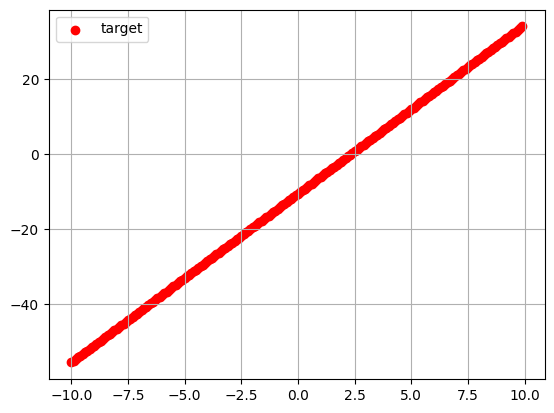

In [201]:
# 1入力1出力の線形関数
def single_linear_func(x:np.ndarray)->np.ndarray:
    """
    x: 1次元のnumpy配列
    return: 1次元のnumpy 配列
    """
    return 4.5*x - 10.5
plot_2d(x, single_linear_func(x))

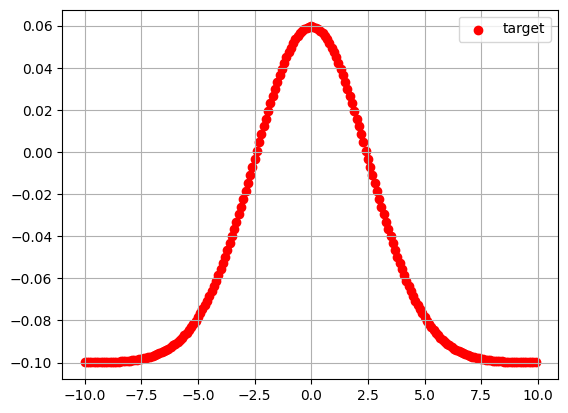

In [202]:
def single_non_linear_func(x:np.ndarray)->np.ndarray:
    """
    1入力1出力の非線形関数
    x: 1次元のnumpy配列
    return: 正規分布を負の値も取るように平行移動させた値
    """
    mean = 0
    sigma = 2.5
    bias = 0.1

    return (1/np.sqrt(2*np.pi*np.square(sigma)))*np.exp(-(x*x-mean)/(2*np.square(sigma))) - bias

plot_2d(x, single_non_linear_func(x))

### 2入力1出力
* 線形関数
* 非線形関数

In [203]:
# 入力する値
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

In [204]:
def plot_3d(X_1, X_2, Y):
    """
    X_1, X_2: 入力となる2次元numpy配列
    Y: X_1, X_2に対応する出力値の2次元numpy配列
    """
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
    ax.plot_surface(X_1, X_2, Y, rstride=1, cstride=10, cmap='jet', alpha=0.4)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

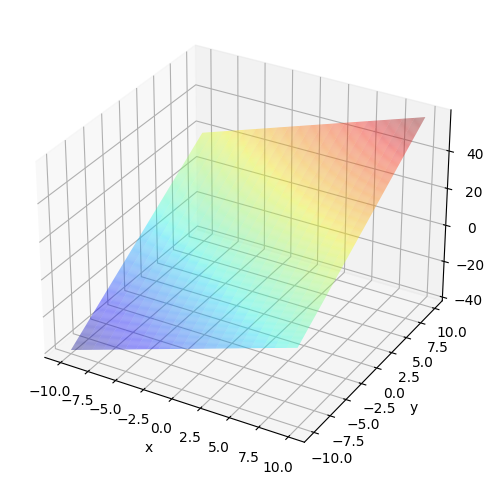

In [205]:
def double_linear_func(x_1:np.ndarray, x_2:np.ndarray)->np.ndarray:
    """
    2入力1出力の線形関数
    x_1, x_2: 入力(2次元配列でも次元数が一致していれば可)
    return: 成分ごとに独立して非線形関数をかました関数
    """
    return 2*x_1 + 3*x_2 + 10

plot_3d(X_1, X_2, double_linear_func(X_1, X_2))

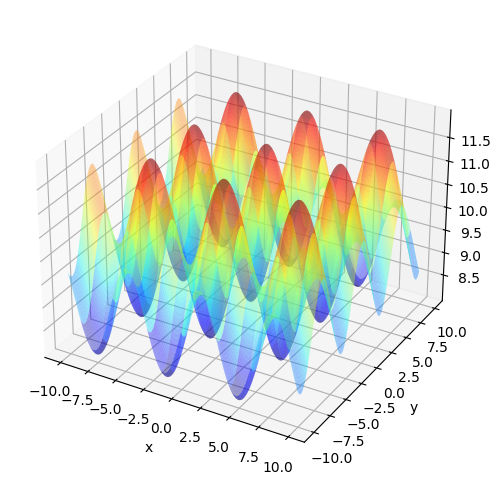

In [206]:
def double_non_linear_func(x_1:np.ndarray, x_2:np.ndarray)->np.ndarray:
    """
    2入力1出力の線形関数
    x_1, x_2: 入力(2次元配列でも次元数が一致していれば可)
    return: 成分ごとに独立して非線形関数をかました関数
    """
    
    return np.sin(x_1) + np.cos(x_2) + 10

plot_3d(X_1, X_2, double_non_linear_func(X_1, X_2))

## ニューラルネットワークの実装
numpyでニューラルネットワークを実装する．層単位でクラスを作成し，それぞれのクラスには以下のメソッドを持たせる．
入力は(バッチ, データの次元)の2次元行列を想定
* forward: 入力値を順伝播する
* backward: 勾配を逆伝播する
* update: learning rateを受け取りパラメータを更新する

In [207]:
class BaseLayer:
    def forward(self):
        raise NotImplementedError("Subclass must implement this method")
    
    def forward(self):
        raise NotImplementedError("Subclass must implement this method")
    
    def update(self):
        raise NotImplementedError("Subclass must implement this method")

In [208]:
class LinearLayer(BaseLayer):
    def __init__(self, hidden_input, hidden_output):
        self.W = random((hidden_input, hidden_output))
        self.B = random(hidden_output)
        self.X = None

        self.dW = None
        self.dB = None

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        self.X = X
        Y = np.dot(self.X, self.W) + self.B
        return Y
    
    def backward(self, dY):
        self.dW = np.dot(self.X.T, dY)
        self.dX = np.dot(dY, self.W.T)
        self.dB = np.sum(dY, axis=0)
        return self.dX
    
    def update(self, lr):
        self.W -= lr*self.dW
        self.B -= lr*self.dB

In [209]:
class MSELayer(BaseLayer):
    def __call__(self, Y, T):
        return self.forward(Y,T)

    def forward(self, Y, T):
        self.Y = Y
        self.T = T
        loss = np.mean(((Y-T)**2)/2)
        return loss
    
    def backward(self):
        batch = self.Y.shape[0]
        d_mse = (self.Y - self.T)/batch
        return d_mse
    
    def update(self, lr):
        pass

In [210]:
class ReLULayer(BaseLayer):
    def __init__(self):
        pass

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        self.X = X
        return np.maximum(self.X, 0)
    
    def backward(self, dY):
        dX = dY*(self.X > 0).astype(np.float64)  # ReLU関数の勾配を計算
        return dX
    
    def update(self, lr):
        pass

In [211]:
class Model:
    def __init__(self, layers:list, loss_layer):
        self.layers = layers
        self.loss_layer = loss_layer

    def __call__(self, X, T):
        return self.forward(X, T)

    def forward(self, X, T):
        # 全ての層に入力を通してlossを返す
        self.X = X
        self.T = T
        for layer in self.layers:
            self.X = layer(self.X)
        loss = self.loss_layer(self.X, self.T)
        return loss
    
    def backward(self):
        reversed_layers = self.layers[::-1]

        dout = self.loss_layer.backward()

        for layer in reversed_layers:
            dout = layer.backward(dout)
        
    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

    def predict(self, X):
        self.X = X
        for layer in self.layers:
            self.X = layer(self.X)
        return self.X

In [212]:
model = Model([
    LinearLayer(2,8),
    ReLULayer(),
    LinearLayer(8,1)
],
MSELayer())
X_test = random((8,2))
T_test = random((8,1))
for epoch in range(0,10):
    print(model(X_test, T_test))
    model.backward()
    model.update(0.01)

14.72860030727952
9.91240637758925
6.938202000372308
4.987235921329271
3.653067219648179
2.7131134452271954
2.0362838590928742
1.5409335762793241
1.1739311847664402
0.8994733753160227


## 学習に用いるクラス設計
* DataLoader: データセットをミニバッチ単位に分割する
* Trainer: 学習の過程や結果などを出力
* plot_history: 学習過程のlossを出力する

In [213]:
class DataLoader:
    def __init__(self, dataset:tuple, batch_size:int):
        """
        イテレーションごとにミニバッチを出力するdataloader
        中途半端なインデックスのデータは捨てる
        dataset: (入力テンソル, 教師テンソル)のtuple
        入力テンソル: (データ数, データ次元)
        教師テンソル: (データ数, データ次元)
        batch_size: ミニバッチサイズ
        """
        self.batch_size = batch_size
        self.batch_num = int(dataset[0].shape[0]/batch_size)  # mini batch数
        self.cut_input = dataset[0][:self.batch_num*batch_size] 
        self.cut_target = dataset[1][:self.batch_num*batch_size] 

    def __iter__(self):
        self.batch_counter = 0  # 何バッチ目まで出力したかを格納
        return self
    
    def __next__(self):
        if self.batch_counter == self.batch_num:
            raise StopIteration
        start = self.batch_counter*self.batch_size
        end = (self.batch_counter+1)*self.batch_size
        minibatch_input = self.cut_input[start:end]
        minibatch_target = self.cut_target[start:end]
        self.batch_counter += 1
        return minibatch_input, minibatch_target

In [214]:
T = double_non_linear_func(X_1, X_2)
def make_dataset(X_1:np.ndarray, T:np.ndarray, X_2=None)->tuple:
    """
    2つの入力の説明変数numpy配列と1つの目的変数numpy配列を受け取り
    (入力np.array, 教師np.array)を返す
    input
    X_1, X_2: 
    2次元(1次元)numpy配列
    np.meshgrid で作成した2次元配列にも対応できる
    T:
    2次元(1次元)numpy配列
    目的変数
    return
    (入力np.array, 教師np.array)それぞれ2次元np.array
    """
    if X_2 is None:
        # 説明変数が1次元の場合
        X = X_1.reshape(-1,1)
        
    else:
        # 説明変数が2次元の場合
        X = np.array([(i,j) for i,j in zip(X_1.reshape(-1), X_2.reshape(-1))])
        
    dataset = (X, T.reshape(-1,1))
    return dataset
dataset = make_dataset(X_1, T, X_2)

In [215]:
dataloader = DataLoader(dataset,8)
for batch in dataloader:
    print(batch[0])
    print(batch[1])

[[-10.  -10. ]
 [ -9.9 -10. ]
 [ -9.8 -10. ]
 [ -9.7 -10. ]
 [ -9.6 -10. ]
 [ -9.5 -10. ]
 [ -9.4 -10. ]
 [ -9.3 -10. ]]
[[9.70494958]
 [9.61846436]
 [9.5274076 ]
 [9.4326891 ]
 [9.33525525]
 [9.23607959]
 [9.13615305]
 [9.03647405]]
[[ -9.2 -10. ]
 [ -9.1 -10. ]
 [ -9.  -10. ]
 [ -8.9 -10. ]
 [ -8.8 -10. ]
 [ -8.7 -10. ]
 [ -8.6 -10. ]
 [ -8.5 -10. ]]
[[8.93803856]
 [8.84183011]
 [8.74880999]
 [8.65990761]
 [8.57601128]
 [8.49795924]
 [8.42653137]
 [8.36244136]]
[[ -8.4 -10. ]
 [ -8.3 -10. ]
 [ -8.2 -10. ]
 [ -8.1 -10. ]
 [ -8.  -10. ]
 [ -7.9 -10. ]
 [ -7.8 -10. ]
 [ -7.7 -10. ]]
[[8.30632956]
 [8.25875664]
 [8.22019791]
 [8.19103866]
 [8.17157022]
 [8.16198713]
 [8.16238513]
 [8.17276024]]
[[ -7.6 -10. ]
 [ -7.5 -10. ]
 [ -7.4 -10. ]
 [ -7.3 -10. ]
 [ -7.2 -10. ]
 [ -7.1 -10. ]
 [ -7.  -10. ]
 [ -6.9 -10. ]]
[[8.1930088 ]
 [8.22292849]
 [8.26222038]
 [8.31049185]
 [8.36726061]
 [8.43195943]
 [8.50394187]
 [8.58248871]]
[[ -6.8 -10. ]
 [ -6.7 -10. ]
 [ -6.6 -10. ]
 [ -6.5 -10. ]
 [ -

In [216]:
class Trainer:
    def __init__(self, model, dataloader, epochs=1000, lr=0.001):
        self.model = model
        self.dataloader = dataloader
        self.epochs = epochs
        self.lr = lr
        self.history = []  # 学習時の損失を記録するlist

    def train(self):
        for epoch in range(0, self.epochs):
            print(f"----------epoch: {epoch+1} start----------")
            loss = 0
            iter_counter = 0
            for batch in dataloader:
                X = batch[0]
                T = batch[1]
                loss += self.model(X, T)
                self.model.backward()
                self.model.update(self.lr)

                iter_counter += 1
            self.history.append(loss/iter_counter)
            print(self.history[-1])
    
    def get_model(self):
        return self.model
    
    def get_history(self)->list:
        return self.history

In [217]:
model = Model([
    LinearLayer(2,20),
    ReLULayer(),
    LinearLayer(20,1)
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=10)
trainer.train()

----------epoch: 1 start----------
0.751969043927323
----------epoch: 2 start----------
0.6307791336862973
----------epoch: 3 start----------
1.0020770580980731
----------epoch: 4 start----------
0.33672937719790197
----------epoch: 5 start----------
0.2455847281797765
----------epoch: 6 start----------
0.23814648548303563
----------epoch: 7 start----------
0.23240420580899995
----------epoch: 8 start----------
0.23252447139648658
----------epoch: 9 start----------
0.2319900300673311
----------epoch: 10 start----------
0.2322562841352897


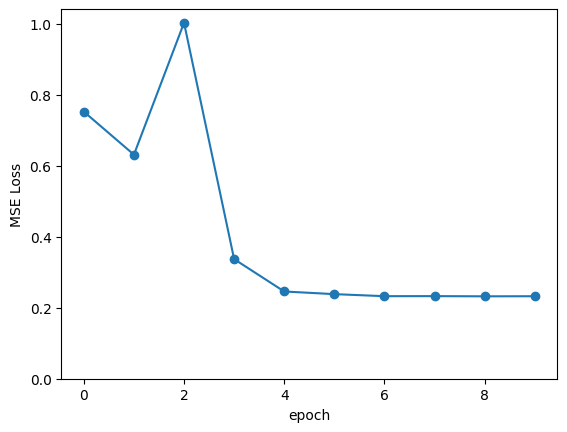

In [218]:
def plot_history(history):
    plt.plot(history, marker="o")
    plt.xlabel("epoch")
    plt.ylabel("MSE Loss")
    plt.ylim(bottom=0)
    plt.show()
plot_history(trainer.history)

## 実際に近似してみる

### 1入力1出力の近似
* 線形関数の線形近似
* 線形関数の非線形近似
* 非線形関数の線形近似
* 非線形関数の非線形近似

----------epoch: 1 start----------
186.11997312874183
----------epoch: 2 start----------
83.64679890748407
----------epoch: 3 start----------
59.913271961512464
----------epoch: 4 start----------
52.25147836378961
----------epoch: 5 start----------
48.34096620220467
----------epoch: 6 start----------
45.51833615820364
----------epoch: 7 start----------
43.115115655562725
----------epoch: 8 start----------
40.929948228509765
----------epoch: 9 start----------
38.89061235920315
----------epoch: 10 start----------
36.966903125265816
----------epoch: 11 start----------
35.144049868640984
----------epoch: 12 start----------
33.41341919155558
----------epoch: 13 start----------
31.768972976918562
----------epoch: 14 start----------
30.205854566995896
----------epoch: 15 start----------
28.71980910135178
----------epoch: 16 start----------
27.306940377353268
----------epoch: 17 start----------
25.963605406262104
----------epoch: 18 start----------
24.686365788285386
----------epoch: 19 start-

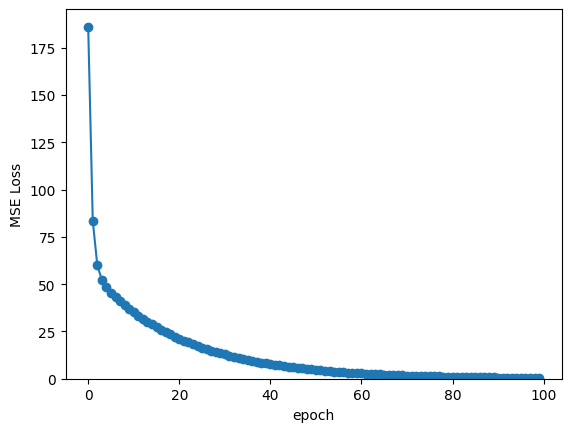

In [219]:
# 線形関数の線形近似
x = np.arange(-10, 10, 0.1)
t = single_linear_func(x)
dataset = make_dataset(x, t)
dataloader = DataLoader(dataset, batch_size=8)
model = Model([
    LinearLayer(1,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=100)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

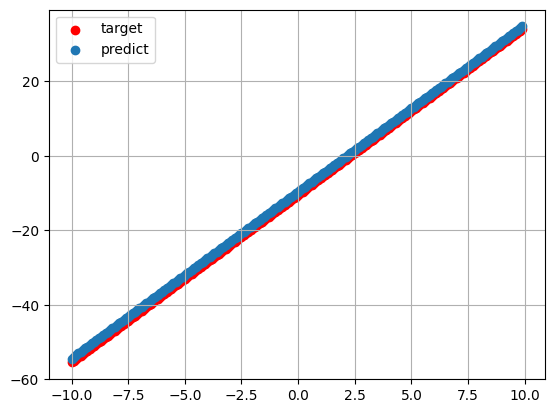

In [220]:
test = trained_model.predict(x.reshape(-1,1))
plot_2d(x, t, trained_model.predict(x.reshape(-1,1)))

----------epoch: 1 start----------
4.785443880072844
----------epoch: 2 start----------
0.8531171121834498
----------epoch: 3 start----------
0.1691276450480904
----------epoch: 4 start----------
0.05408194488136856
----------epoch: 5 start----------
0.03574956360546258
----------epoch: 6 start----------
0.03264659909538705
----------epoch: 7 start----------
0.03144493443892261
----------epoch: 8 start----------
0.030277456981256664
----------epoch: 9 start----------
0.029022940576858423
----------epoch: 10 start----------
0.02774623484671454
----------epoch: 11 start----------
0.026493222819546185
----------epoch: 12 start----------
0.02528482059879814
----------epoch: 13 start----------
0.02412861368984159
----------epoch: 14 start----------
0.02302620051129189
----------epoch: 15 start----------
0.02197668244865297
----------epoch: 16 start----------
0.02097818653578899
----------epoch: 17 start----------
0.02002850692404559
----------epoch: 18 start----------
0.019125369600692783
-

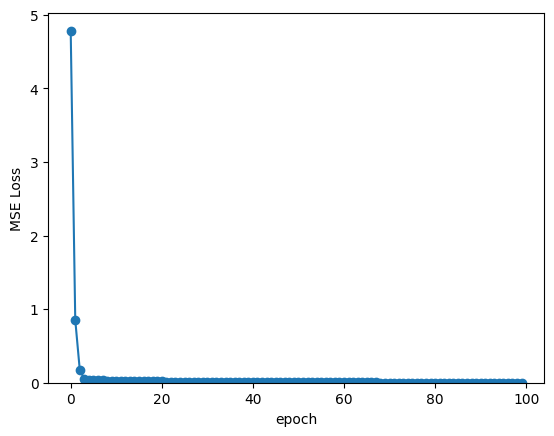

In [221]:
# 非線形関数の線形近似
# 線形関数の線形近似
x = np.arange(-10, 10, 0.1)
t = single_non_linear_func(x)
dataset = make_dataset(x, t)
dataloader = DataLoader(dataset, batch_size=8)
model = Model([
    LinearLayer(1,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=100)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

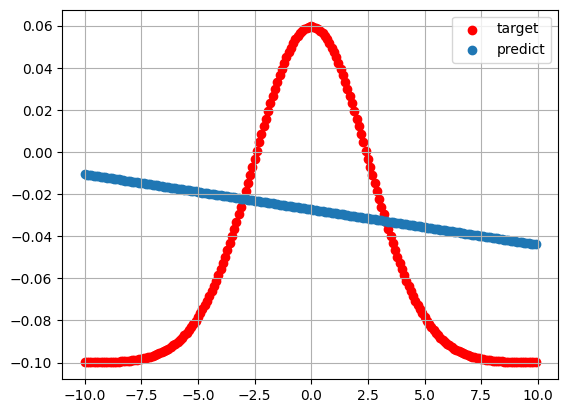

In [222]:
plot_2d(x, t, trained_model.predict(x.reshape(-1,1)))

(200,)
(200,)
----------epoch: 1 start----------
338.48881292244914
----------epoch: 2 start----------
318.1177725177195
----------epoch: 3 start----------
309.32524882137807
----------epoch: 4 start----------
301.21257207906115
----------epoch: 5 start----------
293.53337003218
----------epoch: 6 start----------
286.2067724125281
----------epoch: 7 start----------
279.1837921051892
----------epoch: 8 start----------
272.43453350854014
----------epoch: 9 start----------
265.9339382696253
----------epoch: 10 start----------
259.66792092300443
----------epoch: 11 start----------
253.6248620208118
----------epoch: 12 start----------
247.79208276456583
----------epoch: 13 start----------
242.15898918549047
----------epoch: 14 start----------
236.71676361526804
----------epoch: 15 start----------
231.45746346103252
----------epoch: 16 start----------
226.37203786997273
----------epoch: 17 start----------
221.4525525139944
----------epoch: 18 start----------
216.6909366601213
----------epoch

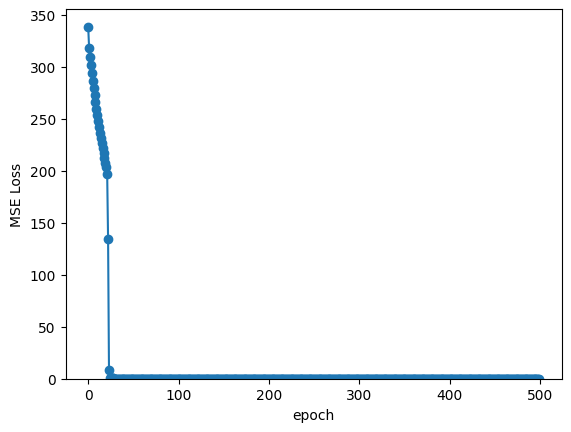

In [223]:
# 線形関数の非線形近似
x = np.arange(-10, 10, 0.1)
t = single_linear_func(x)
print(x.shape)
print(t.shape)
dataset = make_dataset(x, t)
dataloader = DataLoader(dataset, batch_size=8)
model = Model([
    LinearLayer(1,16),
    ReLULayer(),
    LinearLayer(16,1)
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=500)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

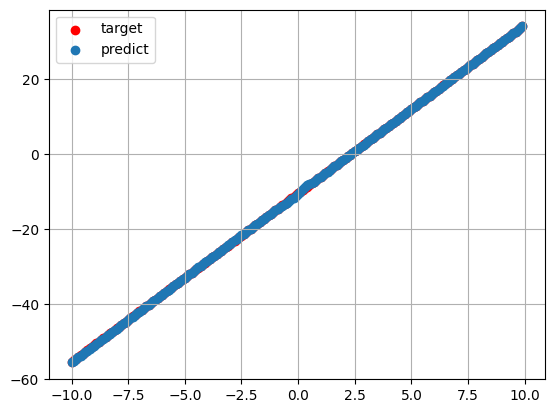

In [224]:
plot_2d(x, t, trained_model.predict(x.reshape(-1,1)))

----------epoch: 1 start----------
6278.5979848034285
----------epoch: 2 start----------
126283.52861911691
----------epoch: 3 start----------
0.15211065721046294
----------epoch: 4 start----------
0.15135980182307218
----------epoch: 5 start----------
0.15061269152827408
----------epoch: 6 start----------
0.14986930764641224
----------epoch: 7 start----------
0.1491296315910004
----------epoch: 8 start----------
0.14839364486825718
----------epoch: 9 start----------
0.14766132907664403
----------epoch: 10 start----------
0.1469326659064049
----------epoch: 11 start----------
0.14620763713910867
----------epoch: 12 start----------
0.14548622464719363
----------epoch: 13 start----------
0.1447684103935139
----------epoch: 14 start----------
0.14405417643088902
----------epoch: 15 start----------
0.14334350490165476
----------epoch: 16 start----------
0.1426363780372167
----------epoch: 17 start----------
0.14193277815760635
----------epoch: 18 start----------
0.14123268767103853
-------

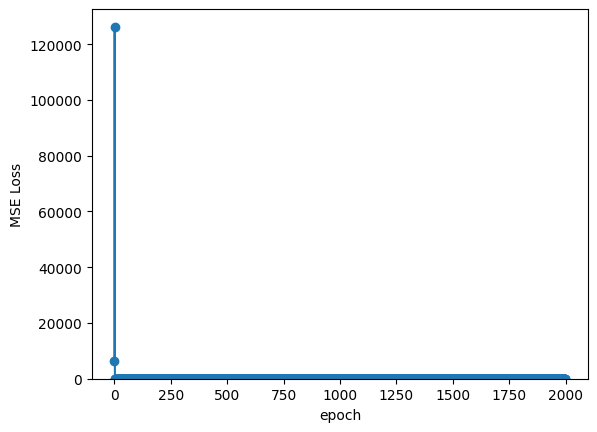

In [225]:
# 非線形関数の非線形近似
x = np.arange(-10, 10, 0.1)
t = single_non_linear_func(x)
dataset = make_dataset(x, t)
dataloader = DataLoader(dataset, batch_size=8)
model = Model([
    LinearLayer(1,32),
    ReLULayer(),
    LinearLayer(32,16),
    ReLULayer(),
    LinearLayer(16,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=2000, lr=0.0001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

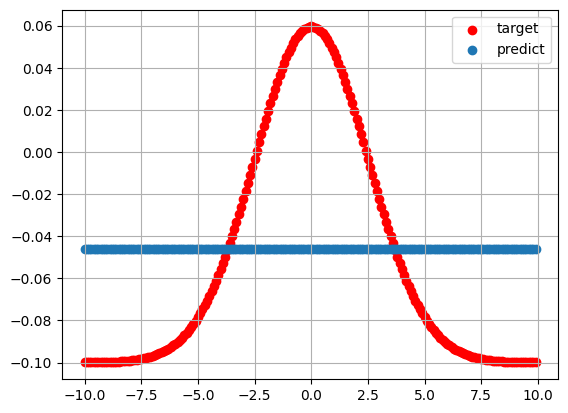

In [226]:
plot_2d(x, t, trained_model.predict(x.reshape(-1,1)))

### 2入力1出力の近似
* 線形関数の線形近似
* 線形関数の非線形近似
* 非線形関数の線形近似
* 非線形関数の非線形近似

----------epoch: 1 start----------
22.20857069553364
----------epoch: 2 start----------
14.4462948304397
----------epoch: 3 start----------
9.22233068813455
----------epoch: 4 start----------
5.887414889598738
----------epoch: 5 start----------
3.7584484068462283
----------epoch: 6 start----------
2.399344142007241
----------epoch: 7 start----------
1.5317098144271908
----------epoch: 8 start----------
0.9778234453894935
----------epoch: 9 start----------
0.6242296558704958
----------epoch: 10 start----------
0.39850002074042745


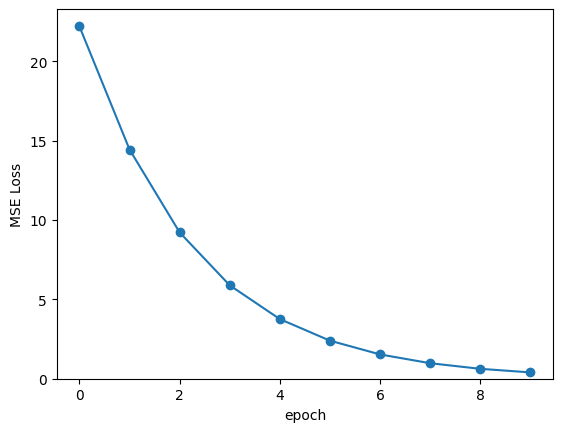

In [227]:
# 線形関数の線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_linear_func(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=10, lr=0.0001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

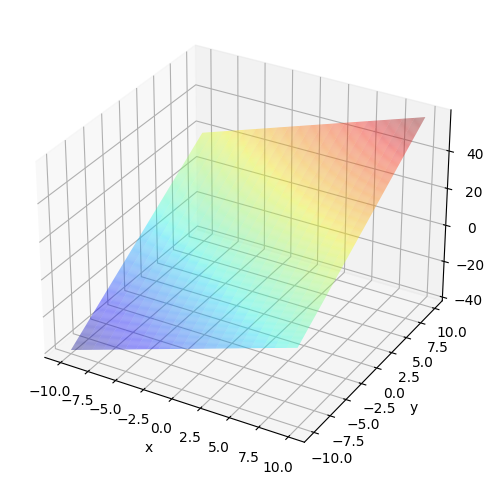

In [228]:
plot_3d(X_1, X_2,T)

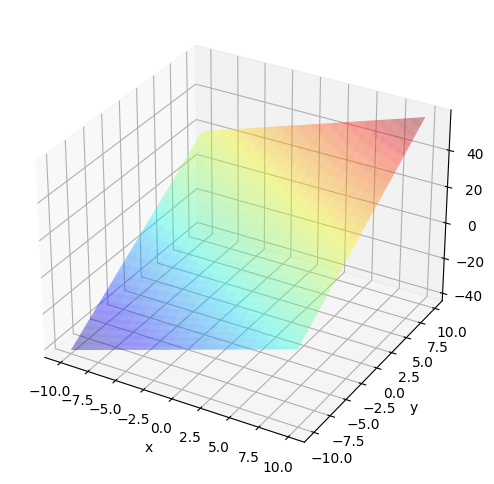

In [231]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

----------epoch: 1 start----------
21.23375758664936
----------epoch: 2 start----------
14.339690470915551
----------epoch: 3 start----------
9.300218771934405
----------epoch: 4 start----------
6.084256031369641
----------epoch: 5 start----------
4.032162878124143
----------epoch: 6 start----------
2.7228808011545182
----------epoch: 7 start----------
1.887649361119354
----------epoch: 8 start----------
1.3549256132321714
----------epoch: 9 start----------
1.0152229164501012
----------epoch: 10 start----------
0.7986657105970744


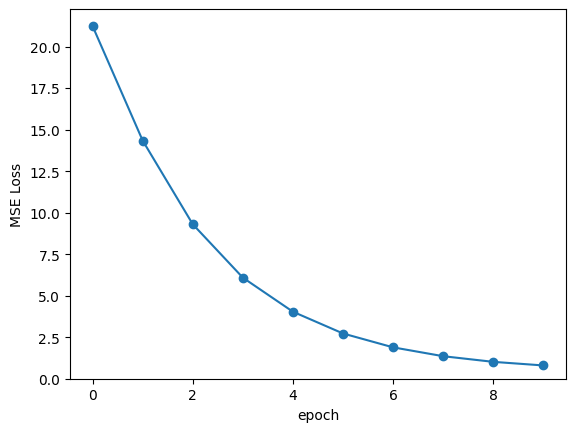

In [232]:
# 非線形関数の線形近似
# 線形関数の線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_non_linear_func(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=10, lr=0.0001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

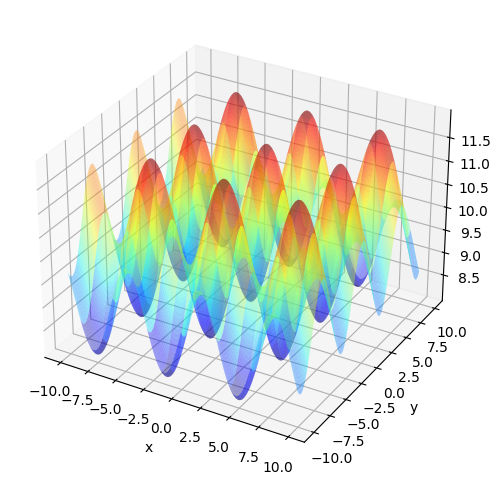

In [233]:
plot_3d(X_1, X_2,T)

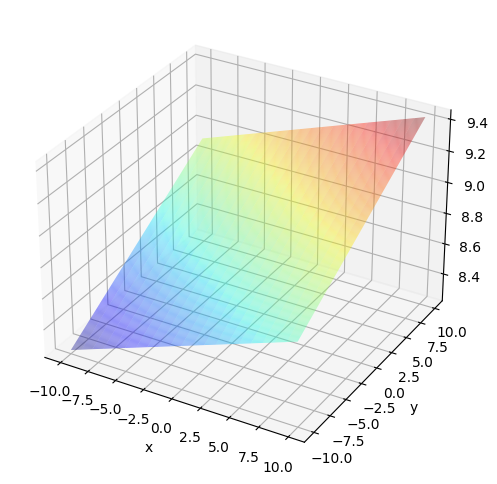

In [234]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

----------epoch: 1 start----------
44.34430447232706
----------epoch: 2 start----------
38.492670372762674
----------epoch: 3 start----------
33.66661443804118
----------epoch: 4 start----------
29.404479199495462
----------epoch: 5 start----------
25.813048164164396
----------epoch: 6 start----------
22.831076858388666
----------epoch: 7 start----------
20.337636978104577
----------epoch: 8 start----------
18.22835402600116
----------epoch: 9 start----------
16.425573855569564
----------epoch: 10 start----------
14.870907098863388


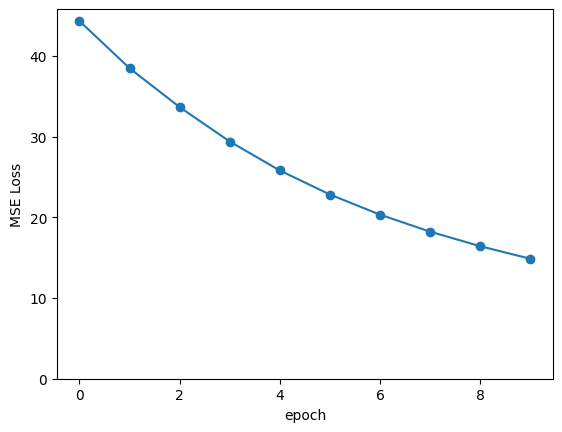

In [238]:
# 線形関数の非線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_linear_func(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,16),
    ReLULayer(),
    LinearLayer(16,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=10, lr=0.0001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

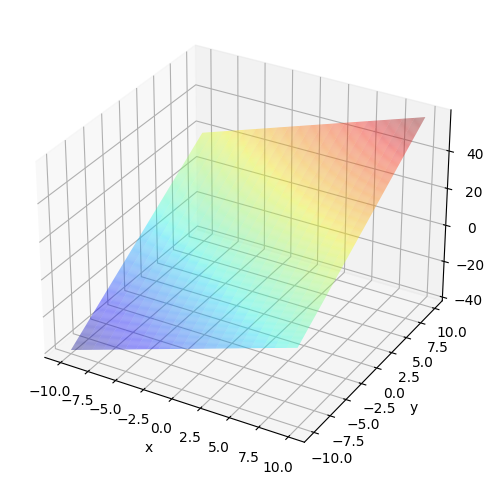

In [239]:
plot_3d(X_1, X_2,T)

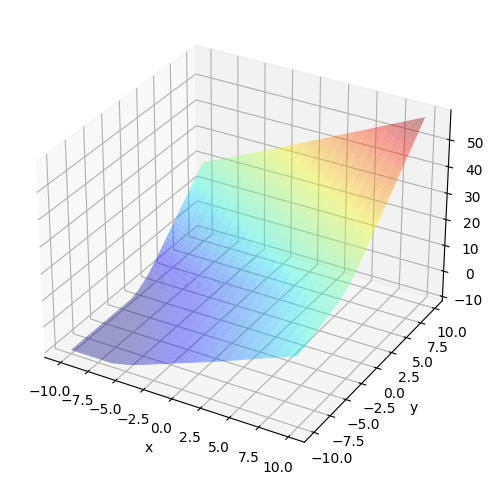

In [240]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))

----------epoch: 1 start----------
2.2757417307803225
----------epoch: 2 start----------
0.8285009120191882
----------epoch: 3 start----------
1.0575430863127993
----------epoch: 4 start----------
0.4303999407901726
----------epoch: 5 start----------
0.4528868050513507
----------epoch: 6 start----------
0.3157671835046331
----------epoch: 7 start----------
0.29498777817841304
----------epoch: 8 start----------
0.2706312305883926
----------epoch: 9 start----------
0.26435218001840005
----------epoch: 10 start----------
0.25633064743131173
----------epoch: 11 start----------
0.2474563701783412
----------epoch: 12 start----------
0.23973604502890322
----------epoch: 13 start----------
0.23402077991552966
----------epoch: 14 start----------
0.23030569455706984
----------epoch: 15 start----------
0.2264353671786074
----------epoch: 16 start----------
0.22258181938634036
----------epoch: 17 start----------
0.21864782448730566
----------epoch: 18 start----------
0.2158022046640557
----------e

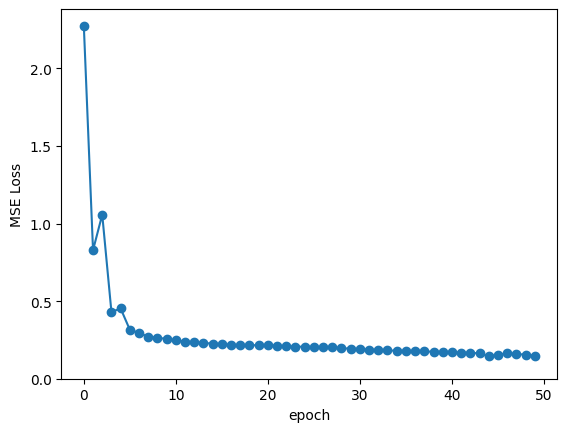

In [257]:
# 非線形関数の非線形近似
# 線形関数の非線形近似
x_1 = np.arange(-10,10, 0.1)
x_2 = np.arange(-10,10, 0.1)
X_1, X_2 = np.meshgrid(x_1, x_2)

T = double_non_linear_func(X_1, X_2)
dataset = make_dataset(X_1, T, X_2)
dataloader = DataLoader(dataset, batch_size=10)

model = Model([
    LinearLayer(2,64),
    ReLULayer(),
    LinearLayer(64,1),
],
MSELayer())
trainer = Trainer(model, dataloader, epochs=50, lr=0.001)
trainer.train()
trained_model = trainer.get_model()
plot_history(trainer.history)

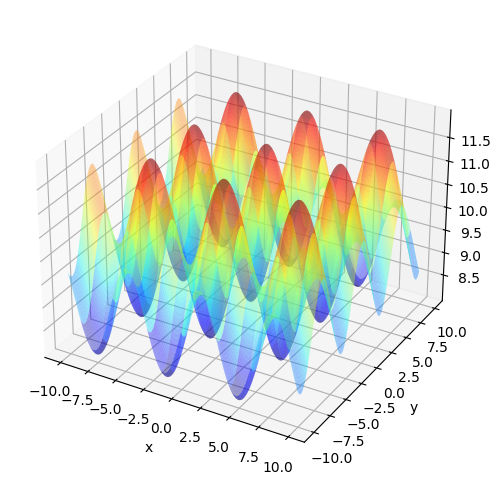

In [258]:
plot_3d(X_1, X_2,T)

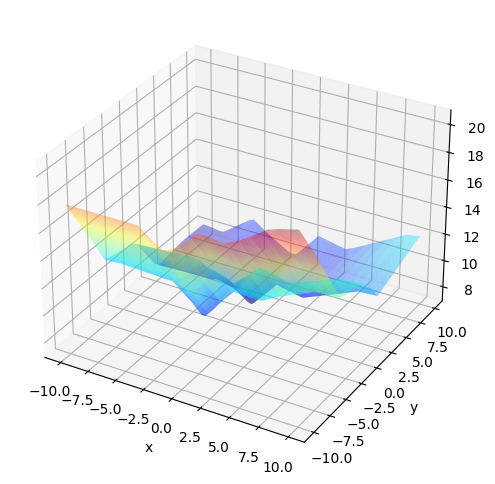

In [260]:
plot_3d(X_1, X_2,trained_model.predict(dataset[0]).reshape(200,200))